# Taxonomist: Application Detection through Rich Monitoring Data
### Emre Ates<sup>1</sup>, Ozan Tuncer<sup>1</sup>, Ata Turk<sup>1</sup>, Vitus J. Leung<sup>2</sup>, Jim Brandt<sup>2</sup>, Manuel Egele<sup>1</sup>, Ayse K. Coskun<sup>1</sup>
<sup>1</sup> Department of Electrical and Computer Engineering, Boston University

<sup>2</sup> Sandia National Laboratories

In the 24th International European Conference on Parallel and Distributed Computing

This Jupyter notebook contains a subset of the raw data collected for the Euro-Par paper with the same title, and necessary code for generating models for detecting applications and testing these models. Our Euro-Par paper can be accessed from www.bu.edu/peaclab/publications after the camera-ready paper submission.

The accompanying files are:
* `requirements.txt`: A list of python packages required, which can be installed by the command `pip install -r requirements.txt`. Python 3 is required, and this document was created using Python 3.6.5
* `README.pdf`: The documentation for setting up this notebook
* `notebook.ipynb`: The interactive Jupyter Notebook
* `notebook.html`: The static Jupyter Notebook
* `data/`: The monitoring data collected from different applications executed on Volta.
    - `metadata.csv`: A csv file listing each run, the IDs of the nodes where each run executed on, which application was executed with which inputs, etc.
    - `timeseries.tar.bz2`: A bzip2 file containing the data collected from the nodes. The unpacked size is **16 GB**, so unpacking is optional for running this notebook.
    - `features.hdf`: An [HDF5 file](https://support.hdfgroup.org/HDF5/) containing pre-calculated features. The calculation process is also included in this notebook.

Things not included in this notebook are:
* The code required for tuning the classifiers. The tuning can be performed by using `sklearn.model_selection.GridSearchCV` as the estimator for `Taxonomist`.
* Code for generating the result for the baselines. The power metric used is `power(W)_cray_aries_r`, which is included in the data. However, generating the features for the baselines require R packages, which is difficult to set up so we excluded that part.

Please refer to `README.pdf` for a full list of differences between our Euro-Par paper and the artifacts in this notebook.

## Setup of the Notebook
The packages are imported here, as well as any constants the user of the notebook has to set.

In [1]:
# Import any packages
from ast import literal_eval
import multiprocessing
import os
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm_notebook as tqdm
from tqdm import TqdmSynchronisationWarning

import taxonomist

warnings.filterwarnings("ignore", category=TqdmSynchronisationWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [2]:
# Constants used
# The path that the package is extracted to
DATA_DIR = Path('./data').expanduser().absolute()
# The number of processes to use for parallel parts
N_JOBS = multiprocessing.cpu_count()
# The base estimator for taxonomist. Can be anything that implements
# A `fit` and `predict_proba` or `decision_function` method.
BASE_ESTIMATOR = RandomForestClassifier(n_estimators=200)
# Whether to use the pre-generated features or generate new ones
GENERATE_FEATURES = False
# Whether to unpack the timeseries and plot them or not
UNPACK_TIMESERIES = False 
# The (name, function) tuples for the features used. These are
# what are used for the paper, but new features can be added.
FEATURE_TUPLES = [
    ('max', np.max),
    ('min', np.min),
    ('mean', np.mean),
    ('std', np.std),
    ('skew', scipy.stats.skew),
    ('kurt', scipy.stats.kurtosis),
    ('perc05', lambda x: np.percentile(x, 5)),
    ('perc25', lambda x: np.percentile(x, 25)),
    ('perc50', lambda x: np.percentile(x, 50)),
    ('perc75', lambda x: np.percentile(x, 75)),
    ('perc95', lambda x: np.percentile(x, 95))
]
# The default figure size
plt.rcParams['figure.figsize'] = [10, 5]
# Turn on grid for figures
plt.rcParams['axes.grid'] = True

In [3]:
# Helper Functions
def report_results(test_labels, predictions):
    print("Precision: {0:.3f}, Recall: {1:.3f}, F-Score: {2:.3f}".format(
        *precision_recall_fscore_support(test_labels, predictions, 
                                         average='weighted')))

## Overview of the Data

The `metadata` file contains metadata about each application run included in this artifact.

In [4]:
metadata = pd.read_csv(DATA_DIR / 'metadata.csv', index_col=0)
metadata['node_ids'] = metadata['node_ids'].apply(literal_eval)
metadata.head()

,platform,app,input,node_ids,start_time,end_time,unwanted,duration
run_id,,,,,,,,
59e5012b57f3f44ead63f567,volta,ft,Y,"[59e5012b57f3f44ead63f563, 59e5012b57f3f44ead6...",1507373566,1507374450,0.0,884
59e5012b57f3f44ead63f56c,volta,ft,Y,"[59e5012b57f3f44ead63f568, 59e5012b57f3f44ead6...",1507374465,1507375341,0.0,876
59e5012c57f3f44ead63f571,volta,ft,Y,"[59e5012c57f3f44ead63f56d, 59e5012c57f3f44ead6...",1506904997,1506905863,0.0,866
59e5012d57f3f44ead63f576,volta,ft,Y,"[59e5012c57f3f44ead63f572, 59e5012c57f3f44ead6...",1506797409,1506798296,0.0,887
59e5012d57f3f44ead63f57b,volta,ft,Y,"[59e5012d57f3f44ead63f577, 59e5012d57f3f44ead6...",1506904157,1506905026,0.0,869


In [5]:
if UNPACK_TIMESERIES:
    if not (DATA_DIR / 'timeseries').exists():
        os.system('cd {}; tar xf {}'.format(DATA_DIR, DATA_DIR / 'timeseries.tar.bz2'))

The HDF files contain the timeseries for each of the runs. We can look at the first node of the application `FT` with the `X` input as an example. We periodically collect 563 metrics from each node. The metrics have the source of the metric as part of the name (e.g., `metric_set_nic`, `procstat`, etc.)

In [6]:
example_node_id = metadata[(metadata['app'] == 'ft') & 
                           (metadata['input'] == 'Y')].iloc[0]['node_ids'][0]
example_timeseries = pd.read_hdf(
    DATA_DIR / 'timeseries' / (example_node_id + '.hdf'))
example_timeseries.head()

,AR_NIC_NETMON_ORB_EVENT_CNTR_REQ_FLITS_metric_set_nic,AR_NIC_NETMON_ORB_EVENT_CNTR_REQ_PKTS_metric_set_nic,AR_NIC_NETMON_ORB_EVENT_CNTR_REQ_STALLED_metric_set_nic,AR_NIC_RSPMON_PARB_EVENT_CNTR_AMO_BLOCKED_metric_set_nic,AR_NIC_RSPMON_PARB_EVENT_CNTR_AMO_FLITS_metric_set_nic,AR_NIC_RSPMON_PARB_EVENT_CNTR_AMO_PKTS_metric_set_nic,AR_NIC_RSPMON_PARB_EVENT_CNTR_BTE_RD_BLOCKED_metric_set_nic,AR_NIC_RSPMON_PARB_EVENT_CNTR_BTE_RD_FLITS_metric_set_nic,AR_NIC_RSPMON_PARB_EVENT_CNTR_BTE_RD_PKTS_metric_set_nic,AR_NIC_RSPMON_PARB_EVENT_CNTR_IOMMU_BLOCKED_metric_set_nic,...,procs_running_procstat,slabs_scanned_vmstat,softirq_count_procstat,softirq_procstat,sys_procstat,unevictable_pgs_culled_vmstat,unevictable_pgs_mlocked_vmstat,unevictable_pgs_munlocked_vmstat,unevictable_pgs_rescued_vmstat,user_procstat
#Time,,,,,,,,,,,,,,,,,,,,,
1507387966,0,0,0,0,159,159,0,0,0,0,...,1,0,22690,0,0,0,0,0,0,0
1507387967,9,3,0,0,159,159,0,2,2,0,...,1,0,22625,0,0,0,0,0,0,0
1507387968,0,0,0,0,159,159,0,0,0,0,...,1,0,22675,0,2,0,0,0,0,0
1507387969,0,0,0,0,159,159,0,0,0,0,...,1,0,22458,1,0,0,0,0,0,0
1507387970,0,0,0,0,159,159,0,0,0,0,...,1,0,22641,0,1,0,0,0,0,0


We plot the CPU time spent in user mode as an example.

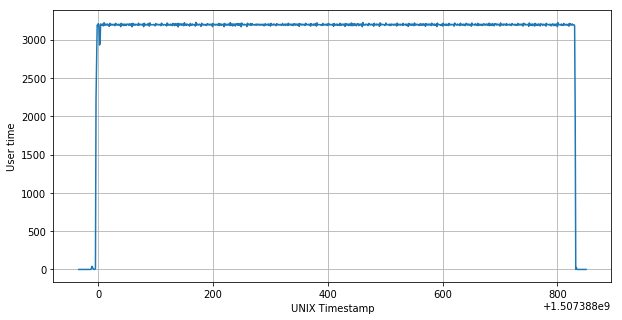

In [7]:
plt.plot(example_timeseries.index, example_timeseries['user_procstat'])
plt.xlabel('UNIX Timestamp')
plt.ylabel('User time')
plt.show()

## Feature Generation
We use the `FEATURE_TUPLES` to define which features are going to be generated. The feature generation might take a long time (half an hour when the notebook is executed using 12 threads). The results are already included as `features.hdf`, so unless `GENERATE_FEATURES` is set, we are not generating the features here.

In [8]:
all_node_ids = [node_id for node_ids in metadata['node_ids'] 
                for node_id in node_ids]

In [9]:
def cache_features(node_id):
    """Generates the features for the given node ids, and stores them"""
    timeseries = pd.read_hdf(DATA_DIR / 'timeseries' / (node_id + '.hdf'))
    return taxonomist.generate_features(timeseries, FEATURE_TUPLES)

In [10]:
if GENERATE_FEATURES:
    with multiprocessing.Pool(N_JOBS) as p:
        # Warning: The errors are not raised within Jupyter Notebook, so if
        # there seems to be no progress, try running this code in the python 
        # REPL to see if there are any errors.
        feature_list = list(tqdm(p.imap(cache_features, all_node_ids), 
                                 total=len(all_node_ids)))
    features = pd.concat(feature_list)
    features.index = all_node_ids
    features.to_hdf(DATA_DIR / 'features.hdf', 'features')

In [11]:
features = pd.read_hdf(DATA_DIR / 'features.hdf')
features.index = all_node_ids
assert set(features.index) == set(all_node_ids)
features.head()

,max_AR_NIC_NETMON_ORB_EVENT_CNTR_REQ_FLITS_metric_set_nic,min_AR_NIC_NETMON_ORB_EVENT_CNTR_REQ_FLITS_metric_set_nic,mean_AR_NIC_NETMON_ORB_EVENT_CNTR_REQ_FLITS_metric_set_nic,std_AR_NIC_NETMON_ORB_EVENT_CNTR_REQ_FLITS_metric_set_nic,skew_AR_NIC_NETMON_ORB_EVENT_CNTR_REQ_FLITS_metric_set_nic,kurt_AR_NIC_NETMON_ORB_EVENT_CNTR_REQ_FLITS_metric_set_nic,perc05_AR_NIC_NETMON_ORB_EVENT_CNTR_REQ_FLITS_metric_set_nic,perc25_AR_NIC_NETMON_ORB_EVENT_CNTR_REQ_FLITS_metric_set_nic,perc50_AR_NIC_NETMON_ORB_EVENT_CNTR_REQ_FLITS_metric_set_nic,perc75_AR_NIC_NETMON_ORB_EVENT_CNTR_REQ_FLITS_metric_set_nic,...,min_user_procstat,mean_user_procstat,std_user_procstat,skew_user_procstat,kurt_user_procstat,perc05_user_procstat,perc25_user_procstat,perc50_user_procstat,perc75_user_procstat,perc95_user_procstat
59e5012b57f3f44ead63f563,251708171,0,8.488983e+07,9.734840e+07,0.633594,-1.215991,0.0,47.0,31054906.0,175712369.0,...,3167,3197.250980,9.724157,-0.062776,0.334579,3182.2,3191.0,3198.0,3203.0,3214.0
59e5012b57f3f44ead63f564,251707494,0,8.488958e+07,9.247342e+07,0.595364,-1.207735,0.0,8.0,46449508.0,173588664.0,...,3167,3197.156863,10.912796,-0.042226,-0.226500,3180.0,3189.0,3199.0,3205.0,3215.0
59e5012b57f3f44ead63f565,251707555,0,8.488960e+07,9.244100e+07,0.595058,-1.207605,0.0,10.0,47638390.0,172981795.0,...,3168,3196.980392,9.004916,-0.030884,0.830260,3179.2,3193.0,3197.0,3201.0,3214.0
59e5012b57f3f44ead63f566,251707494,0,8.488958e+07,1.045421e+08,0.667807,-1.315681,0.0,8.0,76.0,198788583.0,...,3174,3197.345098,7.810576,-0.027800,0.599669,3184.2,3193.0,3199.0,3200.0,3212.0
59e5012b57f3f44ead63f568,251708171,0,8.578694e+07,9.444057e+07,0.595700,-1.219924,0.0,47.0,45645214.0,171000617.0,...,3166,3197.034346,8.536433,0.119504,0.763120,3183.8,3192.0,3197.0,3201.0,3212.0


## Exploration of the Features
We re-create Figure 1 from our Euro-Par paper by using the features. For different views into the data, the features (`X_FEATURE`, `Y_FEATURE`) can be changed as well as `SAMPLE_INPUTS`.

In [12]:
Y_FEATURE = 'mean_nr_slab_unreclaimable_vmstat'
X_FEATURE = 'perc50_nr_inactive_anon_vmstat'
SAMPLE_INPUTS = ['X', 'Y']
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c',
          '#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#f0f099']
markers = ['o', '*', 'D', 'x', 'v', '>', '_', '|', '<', 's', '+']

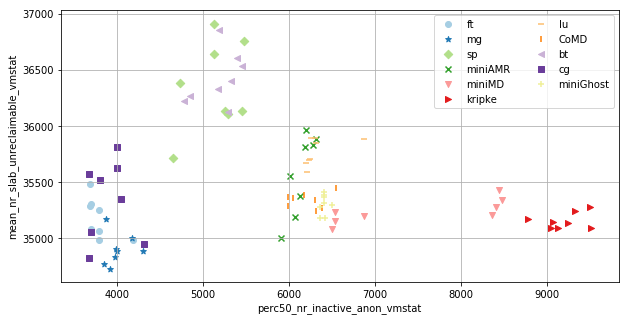

In [13]:
for app, color, marker in zip(metadata['app'].unique(), colors, markers):
    x_coords = []
    y_coords = []
    for input_set in SAMPLE_INPUTS:
        cur_run = metadata[(metadata['app'] == app) & 
                           (metadata['input'] == input_set)].iloc[0]
        cur_nodes = cur_run['node_ids']
        x_coords.extend(features.loc[cur_nodes][X_FEATURE])
        y_coords.extend(features.loc[cur_nodes][Y_FEATURE])
    plt.scatter(x_coords, y_coords, c=color, marker=marker, label=app)
plt.legend(loc='best', ncol=2)
plt.xlabel(X_FEATURE)
plt.ylabel(Y_FEATURE)
plt.show()

## Training the Model
We train our model here. We first split the data into one test set with 20% of the runs, and a training set with the rest.

In [14]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)
train_idx, test_idx = next(k_fold.split(metadata['node_ids'], metadata['app']))
# StratifiedKFold only returns indices to metadata, 
# we need to convert them to node_ids
train_nodes = [node_id for node_ids in metadata.iloc[train_idx]['node_ids'] 
               for node_id in node_ids]
test_nodes = [node_id for node_ids in metadata.iloc[test_idx]['node_ids'] 
              for node_id in node_ids]
# We need separate labels for each node inside an app
train_labels = [app for app, node_ids in 
                zip(metadata.iloc[train_idx]['app'], 
                    metadata.iloc[train_idx]['node_ids']) 
                for _ in node_ids]
test_labels = [app for app, node_ids in 
               zip(metadata.iloc[test_idx]['app'], 
                   metadata.iloc[test_idx]['node_ids']) 
               for _ in node_ids]

We train an instance of `Taxonomist` here. It is a wrapper around a binary classifier which supports prediction probabilities. Inside, it trains one binary classifier separating each application from the rest. After applying the thresholding, any samples below the threshold are labelled as `unknown`.

In [15]:
txm = taxonomist.Taxonomist(BASE_ESTIMATOR, n_jobs=N_JOBS, threshold=0.75)
txm.fit(features.loc[train_nodes], train_labels)

In [16]:
preds = txm.predict(features.loc[test_nodes])

In [17]:
report_results(test_labels, preds)

Precision: 1.000, Recall: 0.997, F-Score: 0.999


## Detecting Unknown Applications

The following code is for re-generating Figure 5 from the paper. We remove each application from the training set, and predict the same test set. We only run this for one out of the 5 folds to shorten the computation. This step also takes a long time (45 minutes with 12 threads)

In [18]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)
train_idx, test_idx = next(k_fold.split(metadata['node_ids'], metadata['app']))
test_nodes = [node_id for node_ids in metadata.iloc[test_idx]['node_ids'] 
              for node_id in node_ids]
global_test_labels = [app for app, node_ids in 
                      zip(metadata.iloc[test_idx]['app'], 
                          metadata.iloc[test_idx]['node_ids']) 
                      for _ in node_ids]
fscores = []
for removed_app in tqdm(metadata['app'].unique()):
    train_metadata = metadata.iloc[train_idx]
    train_metadata = train_metadata[train_metadata['app'] != removed_app]
    train_nodes = [node_id for node_ids in train_metadata['node_ids'] 
                   for node_id in node_ids]
    train_labels = [app for app, node_ids in 
                    zip(train_metadata['app'], 
                        train_metadata['node_ids']) 
                    for _ in node_ids]
    test_labels = [app if app != removed_app else 'unknown' 
                   for app in global_test_labels]
    assert removed_app not in train_labels
    for threshold in tqdm(np.arange(0, 1.05, 0.05), leave=False):
        txm = taxonomist.Taxonomist(BASE_ESTIMATOR, n_jobs=N_JOBS, 
                                    threshold=threshold)
        txm.fit(features.loc[train_nodes], train_labels)
        preds = txm.predict(features.loc[test_nodes])
        fscores.append({
            'removed_app': removed_app,
            'threshold': threshold,
            'f-score': f1_score(test_labels, preds, average='weighted')
        })
fscores = pd.DataFrame(fscores)

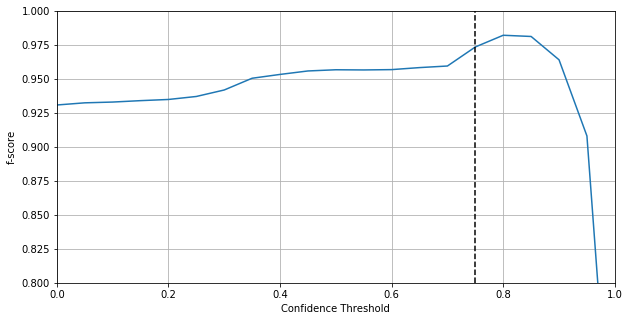

In [19]:
x_coords = fscores['threshold'].unique()
y_coords = []
for thres in x_coords:
    y_coords.append(fscores[fscores['threshold'] == thres]['f-score'].mean())
plt.plot(x_coords, y_coords)
plt.ylabel('f-score')
plt.xlabel('Confidence Threshold')
plt.ylim(0.8, 1)
plt.xlim(0, 1)
plt.axvline(0.75, linestyle='dashed', c='black')
plt.show()

## Acknowledgment
This work has been partially funded by Sandia National Laboratories. Sandia National Laboratories is a multimission laboratory managed and operated by National Technology and Engineering Solutions of Sandia, LLC., a wholly owned subsidiary of Honeywell International, Inc., for the U.S. Department of Energy’s National Nuclear Security Administration under Contract DENA0003525.